### 1. Configuração do Ambiente e Carregamento dos Dados

In [1]:
# Importa o TensorFlow, NumPy e as camadas (layers) que vamos usar para construir os modelos.
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Importa a biblioteca do Colab para permitir o upload de ficheiros.
from google.colab import files

# Solicita o upload do ficheiro .npy que guardámos no Notebook 1.
print("Faça o upload do seu ficheiro 'mnist_processed_images.npy'")
uploaded = files.upload()

# Obtém o nome do ficheiro que acabou de ser carregado.
file_name = next(iter(uploaded))

# Carrega o array de imagens do ficheiro .npy.
train_images = np.load(file_name)

# --- Prepara os dados para o treino ---
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Cria um objeto tf.data.Dataset a partir do nosso array de imagens.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print("\n--- Ambiente Pronto e Dados Carregados! ---")
print(f"Formato do array de imagens carregado: {train_images.shape}")
print("Os dados estão prontos para serem usados no treino.")

Faça o upload do seu ficheiro 'mnist_processed_images.npy'


Saving mnist_processed_images.npy to mnist_processed_images.npy

--- Ambiente Pronto e Dados Carregados! ---
Formato do array de imagens carregado: (42000, 28, 28, 1)
Os dados estão prontos para serem usados no treino.


### 2. Conectei ao Google Drive e defini o caminho do modelo para checkpoint

In [2]:
# Importa a biblioteca para conectar ao Google Drive.
from google.colab import drive
import os

# Pede autorização e monta o seu Google Drive na pasta '/content/drive'.
drive.mount('/content/drive')

# --- Define os caminhos que usaremos ---
# Caminho para a nossa pasta de projeto no Drive.
drive_project_path = '/content/drive/MyDrive/gan_mnist_project/'
# Caminho completo para o nosso ficheiro de dados.
data_file_path = os.path.join(drive_project_path, 'mnist_processed_images.npy')
# Caminho para a pasta onde guardaremos os checkpoints.
checkpoint_dir = os.path.join(drive_project_path, 'training_checkpoints')

# Cria a pasta de checkpoints se ela não existir.
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"Google Drive montado com sucesso!")
print(f"Os checkpoints serão guardados em: {checkpoint_dir}")

Mounted at /content/drive
Google Drive montado com sucesso!
Os checkpoints serão guardados em: /content/drive/MyDrive/gan_mnist_project/training_checkpoints


### 3. Construção e Treino da GAN

In [3]:
# --- FUNÇÃO PARA CRIAR O GERADOR ---
def make_generator_model():
    """Cria e retorna a arquitetura do modelo Gerador."""
    model = tf.keras.Sequential([
        # Camada de entrada que transforma o ruído (semente) numa base para a imagem
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Remodela para um formato de imagem 7x7
        layers.Reshape((7, 7, 256)),

        # Aumenta a imagem para 14x14
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Aumenta a imagem para o tamanho final de 28x28
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# --- FUNÇÃO PARA CRIAR O DISCRIMINADOR ---
def make_discriminator_model():
    """Cria e retorna a arquitetura do modelo Discriminador."""
    model = tf.keras.Sequential([
        # Camada de convolução que analisa a imagem de entrada de 28x28
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3), # Dropout ajuda a prevenir o overfitting

        # Segunda camada de convolução
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        # Achata a imagem para uma única linha de dados
        layers.Flatten(),

        # Camada de saída que dá um único número (um logit) para dizer se a imagem é real ou falsa
        layers.Dense(1)
    ])
    return model

# Cria uma instância de cada modelo
generator = make_generator_model()
discriminator = make_discriminator_model()

print("Modelos Gerador e Discriminador criados com sucesso.")
print("\nArquitetura do Gerador:")
generator.summary()
print("\nArquitetura do Discriminador:")
discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modelos Gerador e Discriminador criados com sucesso.

Arquitetura do Gerador:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         3,200 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,127,488 (8.12 MB)

 Trainable params: 2,102,144 (8.02 MB)

 Non-trainable params: 25,344 (99.00 KB)


Arquitetura do Discriminador:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

### 4. Definir as Funções de Perda e os Otimizadores

In [7]:
import time

# A entropia cruzada binária é a função de perda ideal para este tipo de problema,
# onde a saída é "real" ou "falsa" (0 ou 1).
# from_logits=True é importante porque a nossa última camada do Discriminador não tem uma função de ativação.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# --- Função de Perda do Discriminador ---
# A perda do discriminador é a soma de dois erros:
# 1. O erro ao analisar as imagens reais (ele deve prever 1, mas pode errar).
# 2. O erro ao analisar as imagens falsas (ele deve prever 0, mas pode ser enganado).
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# --- Função de Perda do Gerador ---
# A perda do gerador é mais simples: mede o quão bem ele consegue fazer o discriminador
# prever 1 (real) para as suas imagens falsas.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Criamos um otimizador Adam para cada um dos nossos modelos.
# A taxa de aprendizagem (1e-4) é um valor comum e estável para o treino de GANs.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

print("Funções de perda e otimizadores definidos com sucesso.")

Funções de perda e otimizadores definidos com sucesso.


### 5. Configurar os Checkpoints para Evitar Perdas

In [8]:
# O prefixo do checkpoint define o nome e o local dos ficheiros de checkpoint.
# Eles serão guardados na pasta 'training_checkpoints' no seu Google Drive,
# com nomes como 'ckpt-1', 'ckpt-2', etc.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Cria o objeto Checkpoint.
# Passamos todos os "objetos com estado" que queremos guardar para que possamos
# restaurar o treino exatamente de onde parámos.
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

print(f"Sistema de checkpoints configurado com sucesso.")
print(f"Os ficheiros de progresso serão guardados em: {checkpoint_dir}")

Sistema de checkpoints configurado com sucesso.
Os ficheiros de progresso serão guardados em: /content/drive/MyDrive/gan_mnist_project/training_checkpoints


### 6. Ciclo de Treino do GAN

--- Iniciando o Treino Automatizado da GAN ---
Nenhum checkpoint encontrado. A iniciar o treino do zero.
Imagem de amostra guardada em: /content/drive/MyDrive/gan_mnist_project/image_for_ckpt_0.png


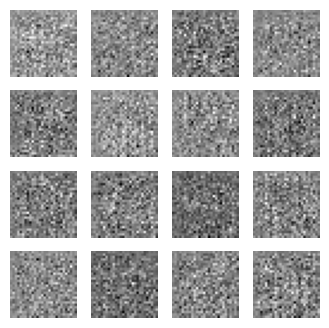

Tempo para a Época 1: 15.41 segundos
Perda do Gerador: 3.4714, Perda do Discriminador: 0.1415

Tempo para a Época 2: 8.46 segundos
Perda do Gerador: 3.9852, Perda do Discriminador: 0.0777

Tempo para a Época 3: 8.53 segundos
Perda do Gerador: 0.9581, Perda do Discriminador: 0.9872

Tempo para a Época 4: 8.58 segundos
Perda do Gerador: 0.9133, Perda do Discriminador: 1.2974

Tempo para a Época 5: 8.64 segundos
Perda do Gerador: 0.9573, Perda do Discriminador: 1.1053

Tempo para a Época 6: 8.68 segundos
Perda do Gerador: 0.7793, Perda do Discriminador: 1.2241

Tempo para a Época 7: 8.73 segundos
Perda do Gerador: 0.9779, Perda do Discriminador: 1.0174

Tempo para a Época 8: 8.77 segundos
Perda do Gerador: 0.9844, Perda do Discriminador: 1.0843

Tempo para a Época 9: 8.84 segundos
Perda do Gerador: 0.8386, Perda do Discriminador: 1.2383

Tempo para a Época 10: 8.87 segundos
Perda do Gerador: 0.8531, Perda do Discriminador: 1.1522

Tempo para a Época 11: 8.92 segundos
Perda do Gerador: 1.0

In [ ]:
# --- PARÂMETROS DE TREINO (PARA UM TREINO LONGO) ---
TOTAL_EPOCHS = 900 # O número total de épocas que queremos treinar.
CHECKPOINT_INTERVAL = 50 # Guardar um checkpoint e uma imagem a cada 50 épocas.
noise_dim = 100
num_examples_to_generate = 16

# Semente fixa para as imagens de amostra, para podermos ver a evolução.
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# --- O CORAÇÃO DO TREINO: A FUNÇÃO TRAIN_STEP ---
# (Esta função permanece a mesma)
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

# --- FUNÇÃO PARA GERAR E GUARDAR IMAGENS ---
def generate_and_save_images(model, epoch, checkpoint_num, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray_r')
        plt.axis('off')

    # Nomeia a imagem de acordo com o número do checkpoint.
    image_save_path = os.path.join(drive_project_path, f'image_for_ckpt_{checkpoint_num}.png')
    plt.savefig(image_save_path)
    print(f"Imagem de amostra guardada em: {image_save_path}")
    plt.show()

# --- O CICLO DE TREINO PRINCIPAL E AUTOMATIZADO ---
def train(dataset, total_epochs):
    gen_loss_history = []
    disc_loss_history = []

    # Tenta restaurar o último checkpoint.
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    start_epoch = 0
    if latest_checkpoint:
        print(f"A restaurar do checkpoint: {latest_checkpoint}")
        checkpoint.restore(latest_checkpoint).assert_existing_objects_matched()
        # Extrai o número da última época guardada para continuar a contagem.
        start_epoch = int(latest_checkpoint.split('-')[-1])
        print(f"A continuar o treino a partir da Época {start_epoch}")
    else:
        print("Nenhum checkpoint encontrado. A iniciar o treino do zero.")
        # Guarda a primeira imagem (não treinada) para referência.
        generate_and_save_images(generator, 0, 0, seed)


    for epoch in range(start_epoch, total_epochs):
        epoch_num = epoch + 1
        start_time = time.time()

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)

        gen_loss_history.append(float(g_loss))
        disc_loss_history.append(float(d_loss))

        print(f'Tempo para a Época {epoch_num}: {time.time()-start_time:.2f} segundos')
        print(f'Perda do Gerador: {g_loss:.4f}, Perda do Discriminador: {d_loss:.4f}\n')

        # Guarda um checkpoint e uma imagem de amostra a cada 50 épocas.
        if epoch_num % CHECKPOINT_INTERVAL == 0:
            checkpoint_num_id = epoch_num // CHECKPOINT_INTERVAL
            checkpoint.save(file_prefix=os.path.join(checkpoint_dir, f"ckpt-{checkpoint_num_id}"))
            print(f'>>> Checkpoint guardado para a Época {epoch_num}! <<<')
            generate_and_save_images(generator, epoch_num, checkpoint_num_id, seed)

    return {'generator_loss': gen_loss_history, 'discriminator_loss': disc_loss_history}

# --- INICIA O TREINO! ---
print("--- Iniciando o Treino Automatizado da GAN ---")
history = train(train_dataset, TOTAL_EPOCHS)

# --- GUARDA O HISTÓRICO FINAL NO GOOGLE DRIVE ---
history_json_path = os.path.join(drive_project_path, 'training_history.json')
# Combina o histórico antigo (se existir) com o novo.
if os.path.exists(history_json_path):
    with open(history_json_path, 'r') as f:
        old_history = json.load(f)
    history['generator_loss'] = old_history.get('generator_loss', []) + history['generator_loss']
    history['discriminator_loss'] = old_history.get('discriminator_loss', []) + history['discriminator_loss']

with open(history_json_path, 'w') as f:
    json.dump(history, f, indent=4)

print(f"\n--- TREINO CONCLUÍDO! ---")
print(f"O histórico final do treino foi guardado em: {history_json_path}")